# Fiber with confined doping
This example showcases pyfiberamp's capability of modelling higher-order modes and user-defined transverse doping profiles. We simulate a high-power fiber amplifier with 20/400 double-clad fiber first with and without the core divided into multiple sections. In particular, we demonstrate that such division is required for physically sensible results. After that, we simulate a fiber with doping confined to the center of the waveguiding core for LP_11 mode suppression. The parameters used are not meant to be especially meaningful or optimized, the main purpose of this example is to show what the simulation model is capable of doing.

## 0) Imports

In [1]:
import numpy as np
from pyfiberamp.fibers import YbDopedDoubleCladFiber, DopingProfile
from pyfiberamp.dynamic import DynamicSimulation
from pyfiberamp.mode_solver import default_mode_solver as mode_solver

## 1) Preparations
### 1.1) Defining and plotting the doping profiles for normal and confined doping fiber
We choose to divide the core into 30 sections (5 radial and 6 angular). This is division is in now way optimized, probably the angular division does not improve accuracy and could be avoided. The confined doping fiber has only 18 sections (3 radial rings). The outermost rings doping concentrations could be set to zero; here they are not even defined to avoid extra computations.

The ordering of the doping sections follows this rule. The first section is in the innermost ring starting from positive x-axis towards counter-clockwise direction. The next section is the counter-clockwise neighbor of the previous section until the first ring is completed. After that the next section (here the 7th) jumps to second-innermost ring, again bordering the positive x-axis in the first coordinate quadrant.

Filled doping profile


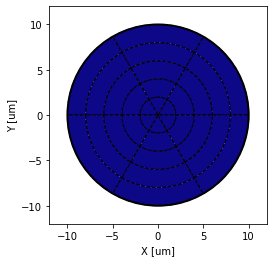

Confined doping profile


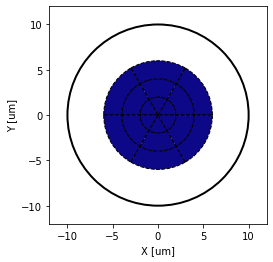

In [2]:
yb_number_density = 5e25
radii = np.array([2, 4, 6, 8, 10])*1e-6
core_radius = 10e-6
doping_radius = 6e-6
filled_doping_profile = DopingProfile(radii=radii,
                                     num_of_angular_sections=6,
                                     ion_number_densities=[yb_number_density]*30,
                                     core_radius=core_radius)
confined_doping_profile = DopingProfile(radii=radii[:-2],
                              num_of_angular_sections=6,
                              ion_number_densities=[yb_number_density]*18,
                              core_radius=core_radius)
print('Filled doping profile')
filled_doping_profile.plot()

print('Confined doping profile')
confined_doping_profile.plot()

### 1.2) Further parameters
We use a typical 20/400 NA 0.065 fiber.
The length of the confined fiber is longer the effective pump absorption is lower.

In [3]:
normal_fiber_length = 12
confined_fiber_length = 30
core_na = 0.065
core_clad_ratio = 20/400
signal_wl = 1064e-9
pump_wl = 976e-9

### 1.3) Basic fiber with core defined as a single element

In [4]:
simple_fiber_20_400 = YbDopedDoubleCladFiber(length=normal_fiber_length,
                                     core_radius=core_radius,
                                     ion_number_density=yb_number_density,
                                     background_loss=0,
                                     core_na=core_na,
                                     ratio_of_core_and_cladding_diameters=core_clad_ratio)

### 1.4) The same fiber but with the core divided into 30 sections
At the moment, the doping profile can only be defined after initializing the fiber. In that case, the ion number density given during initilization is discarded. Here it is set at zero to begin with.

In [5]:
fiber_20_400 = YbDopedDoubleCladFiber(length=normal_fiber_length,
                                     core_radius=core_radius,
                                     ion_number_density=0,
                                     background_loss=0,
                                     core_na=core_na,
                                     ratio_of_core_and_cladding_diameters=core_clad_ratio)
fiber_20_400.doping_profile = filled_doping_profile

### 1.5) Similar fiber but doping confined within 12 um diameter

In [6]:
confined_fiber_20_400 = YbDopedDoubleCladFiber(length=confined_fiber_length,
                                     core_radius=core_radius,
                                     ion_number_density=0,
                                     background_loss=0,
                                     core_na=core_na,
                                     ratio_of_core_and_cladding_diameters=core_clad_ratio)
confined_fiber_20_400.doping_profile = confined_doping_profile

### 1.6) Mode-solving
We solve the LP modes supported by the 20/400 NA 0.065 fiber parameters. At the moment, it is not possible to simulate a more complex waveguide refractive index profile (as perhaps caused by confined doping).

In [7]:
fiber_modes = mode_solver.find_all_modes(core_radius, core_na, signal_wl)
for each in fiber_modes:
    print(each.name)

LP_0,1 mode	
LP_1,1 mode, cos variant
LP_1,1 mode, sin variant


### 1.7) Defining input power and other parameters
We assume that at the input 96 % of the signal power is in the fundamental mode and 2 % is in each of the LP01 mode orientations.

In [8]:
fundamental_mode_content = 0.96
lp11_content = (1 - fundamental_mode_content)
signal_power = 5 # W
LP01_power = fundamental_mode_content * signal_power
LP11_cos_power = 0.5*lp11_content * signal_power
LP11_sin_power = 0.5*lp11_content * signal_power
pump_power = 1000
max_time_steps = 1_000_000
z_nodes = 200

## 2) Simulating the simple fiber with a single core section

LP11 mode content at the output: 2.2 %


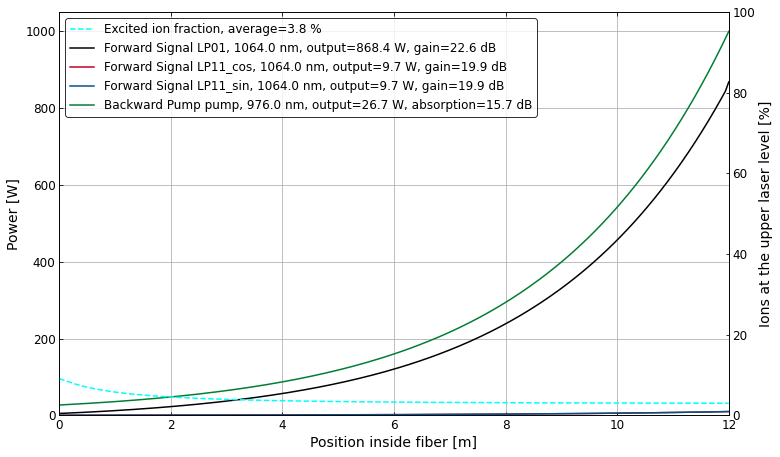

In [9]:
simple_fiber_simulation = DynamicSimulation(max_time_steps, simple_fiber_20_400)
simple_fiber_simulation.add_forward_signal(wl=signal_wl,
                                           input_power=LP01_power,
                                           mode=fiber_modes[0],
                                           channel_id='LP01')
simple_fiber_simulation.add_forward_signal(wl=signal_wl,
                                           input_power=LP11_cos_power,
                                           mode=fiber_modes[1],
                                           channel_id='LP11_cos')
simple_fiber_simulation.add_forward_signal(wl=signal_wl,
                                           input_power=LP11_sin_power,
                                           mode=fiber_modes[2],
                                           channel_id='LP11_sin')
simple_fiber_simulation.add_backward_pump(wl=pump_wl,
                                          input_power=pump_power,
                                          channel_id='pump')

simple_res = simple_fiber_simulation.run(z_nodes, dt=1e-7, stop_at_steady_state=True)
output_lp11_content = np.sum(simple_res.powers.forward_signal[1:, -1]) / simple_res.powers.forward_signal[0, -1]
print(f'LP11 mode content at the output: {output_lp11_content*100:.1f} %')
simple_res.plot_power_evolution()

The naive simulation predicts that the fundamental mode would experience higher gain (due to its better overlap with the core) than the LP11 modes. However, this is misleading, since pump power is absorbed evenly within the cross section of the core but the fundamental mode can saturate inversion mostly at the center of the core. The edges having higher inversion should result in larger gain for the LP11 modes.

## 3) Simulating the same fiber with core divided into sections

LP11 mode content at the output: 11.0 %


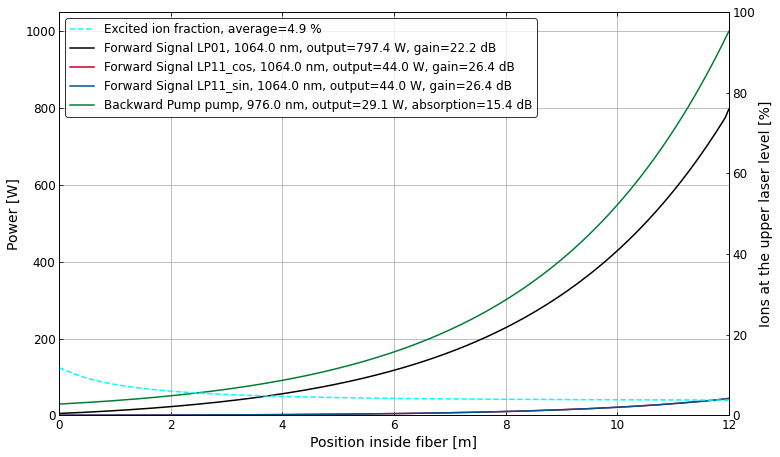

In [10]:
normal_fiber_simulation = DynamicSimulation(max_time_steps, fiber_20_400)
normal_fiber_simulation.add_forward_signal(wl=signal_wl,
                                           input_power=LP01_power,
                                           mode=fiber_modes[0],
                                           channel_id='LP01')
normal_fiber_simulation.add_forward_signal(wl=signal_wl,
                                           input_power=LP11_cos_power,
                                           mode=fiber_modes[1],
                                           channel_id='LP11_cos')
normal_fiber_simulation.add_forward_signal(wl=signal_wl,
                                           input_power=LP11_sin_power,
                                           mode=fiber_modes[2],
                                           channel_id='LP11_sin')
normal_fiber_simulation.add_backward_pump(wl=pump_wl,
                                          input_power=pump_power,
                                          channel_id='pump')

normal_res = normal_fiber_simulation.run(z_nodes, dt=1e-7, stop_at_steady_state=True)
output_lp11_content = np.sum(normal_res.powers.forward_signal[1:, -1]) / normal_res.powers.forward_signal[0, -1]
print(f'LP11 mode content at the output: {output_lp11_content*100:.1f} %')
normal_res.plot_power_evolution()

This result looks more realistic. The initial LP11 mode content was 4 %, but after amplification it has grown to ~11 %. To verify that this effect is due to higher inversion at the edges of the core, we can plot the transverse excitation profile of the fiber. First, this the excitation profile at the start of the fiber.

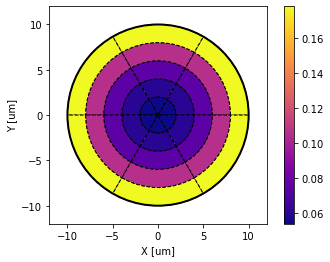

In [11]:
normal_res.plot_transverse_inversion(z_idx=0)

The relative inversion at the outer edge of the core where LP11 amplitude is larger than LP01 amplitude is almost three times higher than at the center. Note also that the inversion is rotationally symmetric since both LP11 modes are present in equal proportion.
Let's then check the transverse inversion at the end of the fiber:

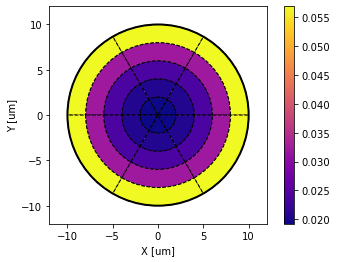

In [12]:
normal_res.plot_transverse_inversion(z_idx=-1)

The average inversion is much lower, but the picture is otherwise very similar. The fundamental mode cannot properly saturate the edges of the core, leaving extra gain for the LP11 modes.

## 4) Simulating a fiber with confined doping
The normal way to suppress higher order modes is to coil the fiber sufficiently tightly so that bending losses suppress the LP11 modes while the LP01 mode does not yet suffer noticeable losses. It is possible to set a background loss value for each channel to simulate this, though pyfiberamp does not have a theoretical computation of bend losses at the moment. For demonstration purposes, we ignore bend losses and only consider confined doping for LP11 suppression. The idea is basically to keep only the center part of the transverse doping profile plotted above. If the edges of the core where LP01 intensity is low are undoped, then LP11 modes should be greatly suppressed. On the other hand, the fiber must be significantly longer as the pump absorption is reduced.

LP11 mode content at the output: 0.4 %


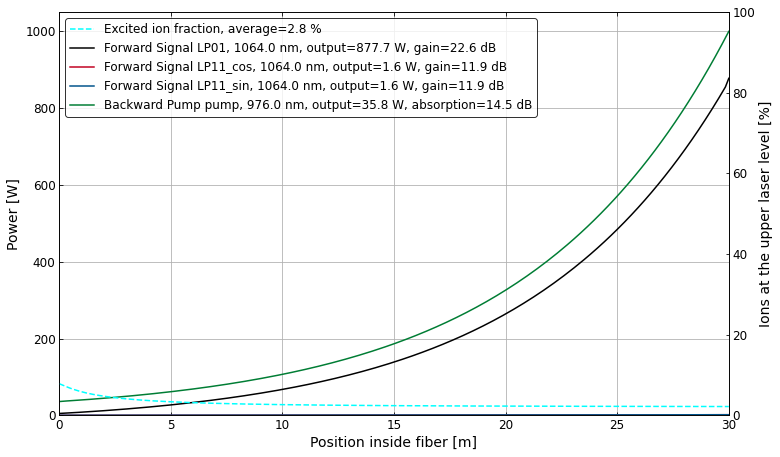

In [13]:
confined_fiber_simulation = DynamicSimulation(max_time_steps, confined_fiber_20_400)
confined_fiber_simulation.add_forward_signal(wl=signal_wl,
                                           input_power=LP01_power,
                                           mode=fiber_modes[0],
                                           channel_id='LP01')
confined_fiber_simulation.add_forward_signal(wl=signal_wl,
                                           input_power=LP11_cos_power,
                                           mode=fiber_modes[1],
                                           channel_id='LP11_cos')
confined_fiber_simulation.add_forward_signal(wl=signal_wl,
                                           input_power=LP11_sin_power,
                                           mode=fiber_modes[2],
                                           channel_id='LP11_sin')
confined_fiber_simulation.add_backward_pump(wl=pump_wl,
                                            input_power=pump_power,
                                            channel_id='pump')

confined_res = confined_fiber_simulation.run(z_nodes, dt=1e-7, stop_at_steady_state=True)
output_lp11_content = np.sum(confined_res.powers.forward_signal[1:, -1]) / confined_res.powers.forward_signal[0, -1]
print(f'LP11 mode content at the output: {output_lp11_content*100:.1f} %')
confined_res.plot_power_evolution()

This seems to work. The LP11 modes experience significantly less gain than the LP01 mode. The higher order mode content drops from 4 % to 0.4 % during amplification even though bend losses are neglected. On the other hand, the fiber length had to be increased fro 12 m to ~30 m to reach a similar gain. It looks like the selected 6 um doping radius could be too tight to be optimal. Let's again plot the transverse doping profiles at the start and the end of the fiber.

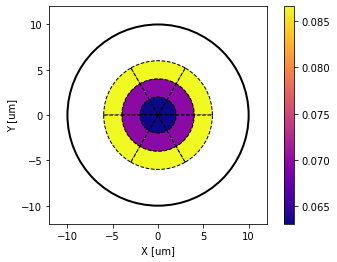

In [14]:
confined_res.plot_transverse_inversion(z_idx=0)

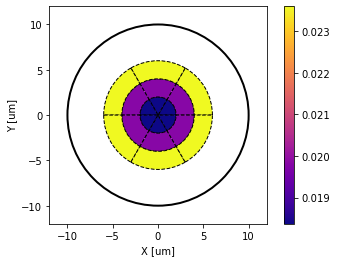

In [15]:
confined_res.plot_transverse_inversion(z_idx=-1)

Even though the center still has the highest saturations, the inversion at the edges of the confined doping profile is not much larger, in agreement with the amplification results.

## Extra: Simulation of fiber with purely LP11 signal
This is a highly unrealistic scenario, but for demonstration purposes let's simulate the normal (non-confined) fiber with only a single LP11 mode (cos variant) as the input signal.

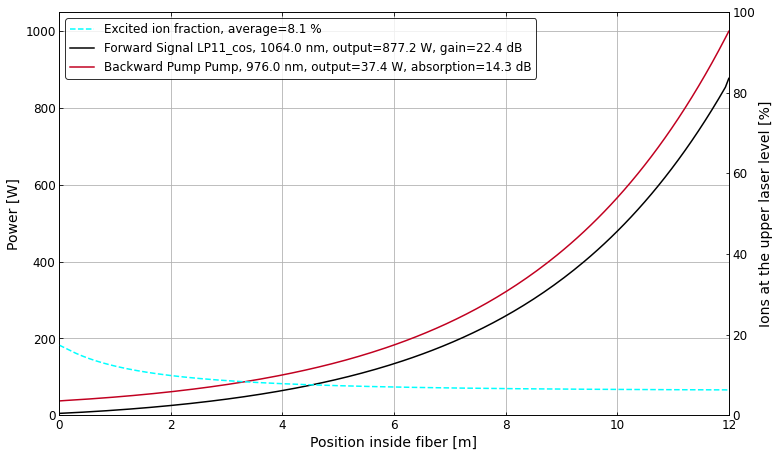

In [16]:
single_lp11_simulation = DynamicSimulation(max_time_steps, fiber_20_400)
single_lp11_simulation.add_forward_signal(wl=signal_wl,
                                           input_power=signal_power,
                                           mode=fiber_modes[1],
                                           channel_id='LP11_cos')

single_lp11_simulation.add_backward_pump(wl=pump_wl, input_power=pump_power, channel_id='Pump')
single_lp11_res = single_lp11_simulation.run(z_nodes, dt=1e-7, stop_at_steady_state=True)
single_lp11_res.plot_power_evolution()

We can plot the mode and the simulated transverse inversion profiles in the fiber. Since a single LP11 mode is not rotationally symmetric, we can expect to see some angular variation in the doping profiles.

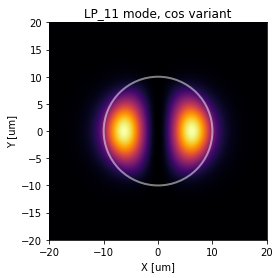

In [17]:
lp11_cos_mode = fiber_modes[1]
lp11_cos_mode.plot_intensity()

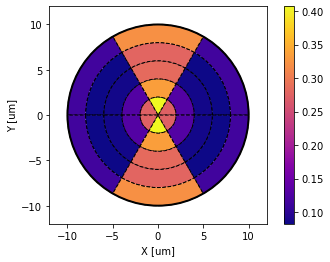

In [18]:
single_lp11_res.plot_transverse_inversion(z_idx=0)

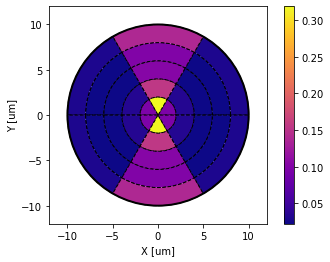

In [19]:
single_lp11_res.plot_transverse_inversion(z_idx=-1)

And this is exactly what we see: The inversion is clearly highest in the regions where the mode intensity is weak, especially at the center of the fiber.

If you want to ask a question or send feedback about this example, please open a new issue on GitHub or contact me at <pyfiberamp@gmail.com>.